In [16]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [2]:
#import tensorflow dependencies
#tensorflow functional api
#siamese neural network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
# Avoid OOM errors by setting gpu memoty consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
#pass in the input (or anchor) imagage and test it against a positive (the same) and a negative (different) image
#the neural network will return 0 if the two images are different and 1 if they are the same
#start with an anchor and a positive or negative comparison, pass those to the model then to a distance layer

In [17]:
#setup paths (folders)
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
#make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [ ]:
#positive images are images that match the input image
    #ie they are the same object
#negative images are images that do not match the input image
#the model tries to determine the difference between the input (anchor) and positive image
#an output of 1 means the two images match aka verified for facial rec
#for a family household, the anchor image needs to be compared with everyone in the family
#need to collect anchor, postive and negative to train model




In [ ]:
#uncompress tar GZ labelized faces in the wild dataset
!tar -xf lfw.tgz

In [ ]:
#move lfw images to the following repository (negative folder)
#goes into each folder in lfw and moves each picture that is in there
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw',directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [7]:
#import uuid library to generate unique image names
import uuid

In [78]:
#negative image sizes are 250x250

cap=cv2.VideoCapture(1)  #establish a connection to the webcam
while cap.isOpened():    #loop through the frames from the webcam
    ret,frame = cap.read()  #unpack and get a single frame
    
    #cut down frame to 250x250 pixels
    frame = frame[300:300+250,540:540+250,:]
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)   
            
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):  
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)   
            
    
    cv2.imshow('Image Collection', frame)   #show image back to screen
    
    if cv2.waitKey(1) & 0XFF == ord('q'):   #breaking gracefully
        break                               #if it waits a millisecond and q is hit on the keyboard, it quits
cap.release()            #close the image show frame
cv2.destroyAllWindows()

In [ ]:
#tensorflow data input pipeline
#load folders
#create a preproccessing pipeline
#associate the positive and negative classes

In [18]:
#grab all the image directories 

anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300) #take(len(os.listdir(os.path.join('data', 'anchor'))))
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)  #take(len(os.listdir(os.path.join('data', 'positive'))))
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)  #take(len(os.listdir(os.path.join('data', 'negative'))))

In [22]:
#preprocessing - scale and resize
def preprocess(file_path):
    
    #read in image from file path
    byte_img = tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    #preprocessing steps- resize the image to be 100 pixels x 100 pixels x 3 colors
    img = tf.image.resize(img, (100,100))
    #scale image to be between 0 and 1
    img = img / 255.0
    
    #return image
    return img

In [23]:
# (anchor, positive) => 1,1,1,1 array of 1s
# (anchor, negative) => 0,0,0,0 array of 0s
# puts togethor the positive and negative images so that the model will know when two images are supposed to return a 0 and a 1


In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
#structure:
#file path to anchor, file path to pos or neg, label representing a pos or neg case


In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
# build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [28]:
#training partition
train_data = data.take(round(len(data)*.7)) #take first 70 percent of data
train_data = train_data.batch(16)   #pass in data as batches of 16
train_data = train_data.prefetch(8)  #starts preprcoessing the next batch before the end of the curent batch

In [29]:
# testing partition
test_data = data.skip(round(len(data)*.7))  #skips the first 70 percent
test_data = test_data.take(round(len(data)*.3))  #takes the last 30 percent
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [21]:
# 1. build an embedding layer (converts a raw image to a data representation that is passed to the simese NN)
# 2. create an L1 distance layer (determines if the embedding layers, anchor and pos/neg image, are similar enough to be verified)
# 3. compile the siamese network

In [22]:
#form a core block
#will get replicated a few times
#each block is another convolution and max-pooling layer but with different filters

def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')   #input image
   
    #first block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)  #64 filter, 10x10 pixel size, relu activation
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)  #64 units, shape of 2x2, condenses data (returns the max value out of a 2x2 area)
                                                      #padding is the same so the output shape is the same
    #second block
    c2 = Conv2D(128,(7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)
    
    #third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
    
    #fourth (final) block is a conv and a fully connected layer
    c4= Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)       #flattens the 3 convolution layers (3 dimensions) into one dimension
    d1 = Dense(4096, activation='sigmoid')(f1) #feature vector
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [23]:
embedding = make_embedding()

In [24]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [4]:
#Siamese L1 distance class
#L1 distance layer: tells you how similar two pictures are
#imput is the 

class L1Dist(Layer):
    
    #init mehtod - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    #important stuff
    #tells the layer what to do when data is passed to it
    #subtracts the validation of the anchor and pos/neg embedding
    #returns an absolute value of the difference
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [26]:
#bring everthing togethor

def make_siamese_model():
    
    #Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #validation image in the network
    validation_image= Input(name='vaidation_img', shape=(100,100,3))
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)
    distances = siamese_layer(inp_embedding, val_embedding)
    
    #classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

    

In [27]:
siamese_model = make_siamese_model()

In [28]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 vaidation_img (InputLayer)  [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'vaidation_img[0][0]']       
                                                                                                  
 distance (L1Dist)           (None, 4096)                 0         ['embedding[0][0]

In [29]:
# Training:

# 1. set up a loss function
# 2. set up an optimizer
# 3. build a custom training step - the training done on each step
# 4. create a training loop
# 5. train the model

# checkpoints allow for a reload point in case something goes wrong, and a complete restrat is not needed



In [7]:
# loss and optimizer
#Adam optimizer runs slowly on M1- use .legacy 

#tensorflow loss 
binary_cross_loss = tf.losses.BinaryCrossentropy()

#tensorflow adam optimizer
opt = tf.keras.optimizers.legacy.Adam(1e-4)  #learnig rate of 0.0001

In [31]:
#checkpoints

checkpoint_dir = './training_checkpoints'  #new directory to save the checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')  #checpoint prefix
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)  #saves the current optimizer and siamese model

In [32]:
#train step function
#used to train on one batch of data
#make a prediciton, calculate loss, calculate gradients, apply back propogation through the NN to ge tthe best possible model

#nasic flow for training one batch:
   # 1. make a predicition
   # 2. calculate loss
   # 3. derive gradients
   # 4. calculate new weights and apply

@tf.function   #compiles a function into a callable tensorFlow graph
def train_step(batch):  #batch = batch of data
    
    with tf.GradientTape() as tape:
        #get anchor and pos/neg image (features)
        X = batch[:2]  # 0 is the anchor image index, 1 is the pos/neg, and 2 is the label (ie 1 or 0)
        #get label
        y = batch[2]
        
        # forward pass
        yhat = siamese_model(X, training=True)   #important for training to be set to true
                                                 # hat notation is for estimations, so y hat is the mode's estimation for the label, ie its guess on how similar two pictures are
        #calculate loss
        loss = binary_cross_loss(y, yhat)        #difference between actual y value and y_hat

    #calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [33]:
# training loop

def train(data, EPOCHS):
    #loop through the epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))  #progress bar
    
        #loop through each batch
        for idx, batch in enumerate(data):
            #run train step here
            train_step(batch)
            progbar.update(idx+1)
              
        #save the checkpoints, saves a checkpoint every 10 epochs
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
              
            

In [34]:
#train the model

EPOCHS = 50

train(train_data, EPOCHS)


 Epoch 1/50
27/27 [==============================] - 78s 3s/step

 Epoch 2/50
27/27 [==============================] - 77s 3s/step

 Epoch 3/50
27/27 [==============================] - 77s 3s/step

 Epoch 4/50
27/27 [==============================] - 76s 3s/step

 Epoch 5/50
27/27 [==============================] - 76s 3s/step

 Epoch 6/50
27/27 [==============================] - 77s 3s/step

 Epoch 7/50
27/27 [==============================] - 76s 3s/step

 Epoch 8/50
27/27 [==============================] - 76s 3s/step

 Epoch 9/50
27/27 [==============================] - 76s 3s/step

 Epoch 10/50
27/27 [==============================] - 76s 3s/step

 Epoch 11/50
27/27 [==============================] - 76s 3s/step

 Epoch 12/50
27/27 [==============================] - 76s 3s/step

 Epoch 13/50
 9/27 [=========>....................] - ETA: 51s

KeyboardInterrupt: 

In [31]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [33]:
siamese_model = tf.keras.models.load_model('siamesemodel.keras', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

1/1 [==============================] - 1s 840ms/step
0


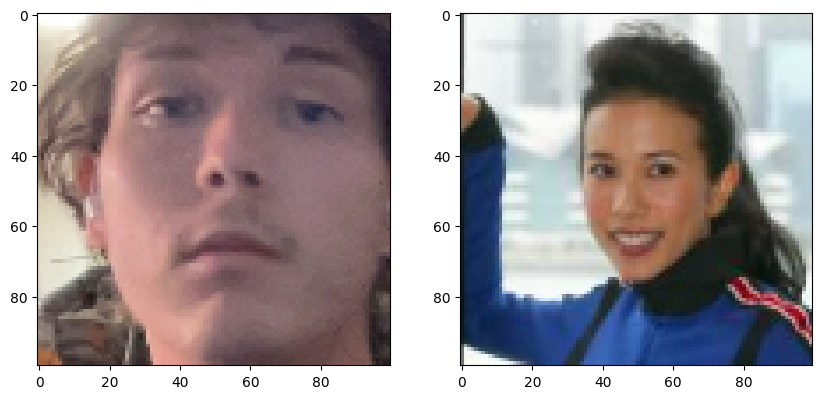

1


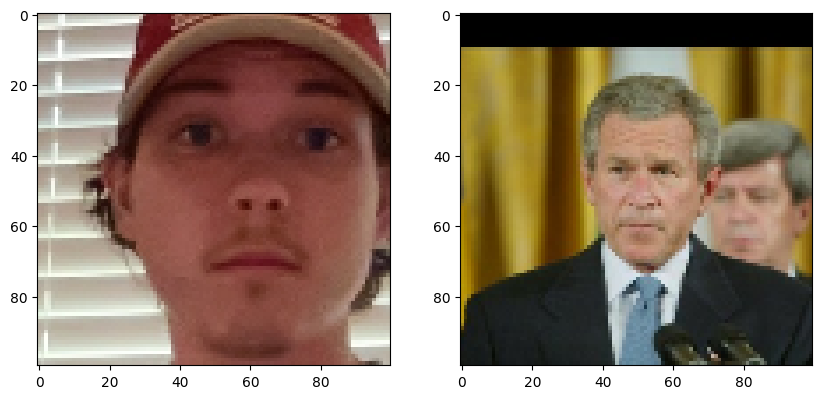

4


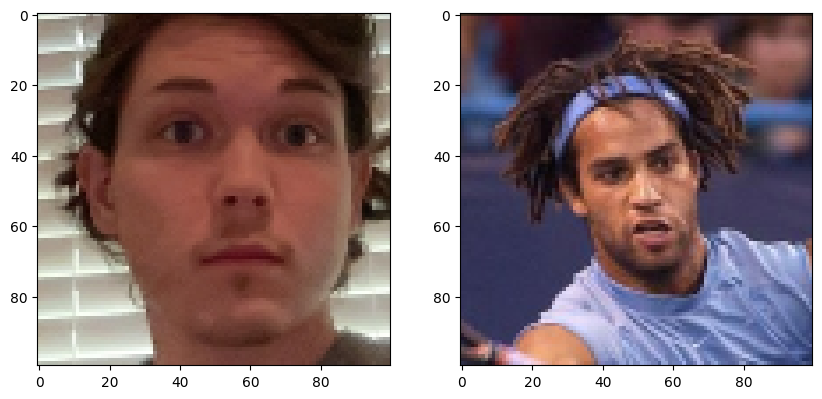

7


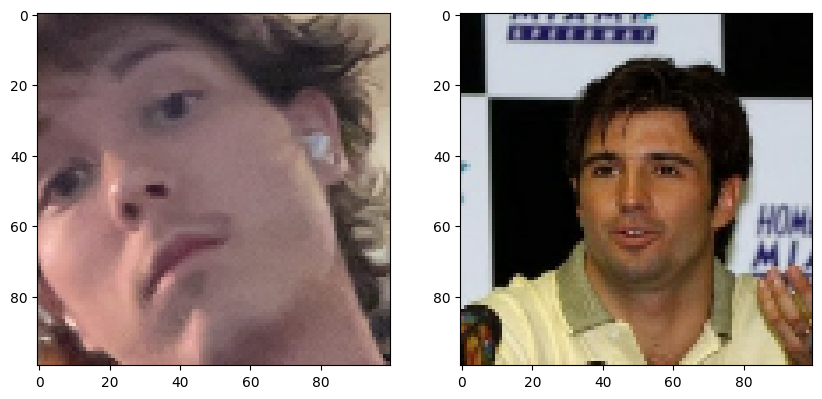

11


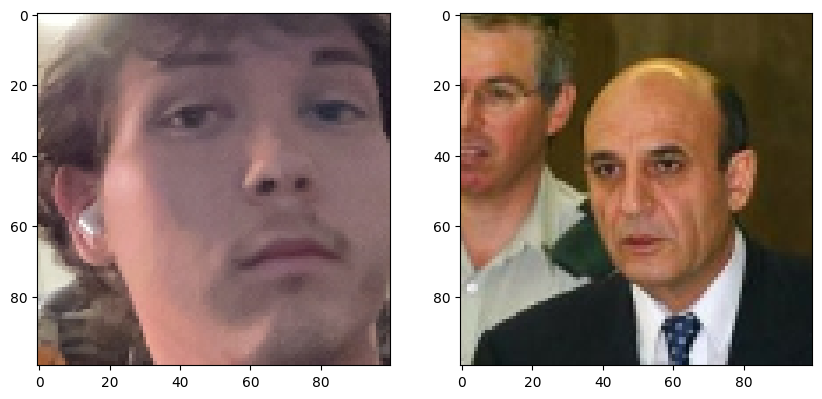

12


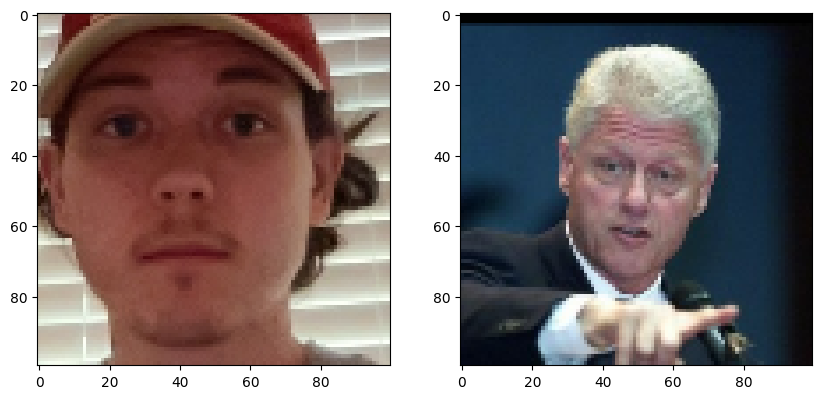

13


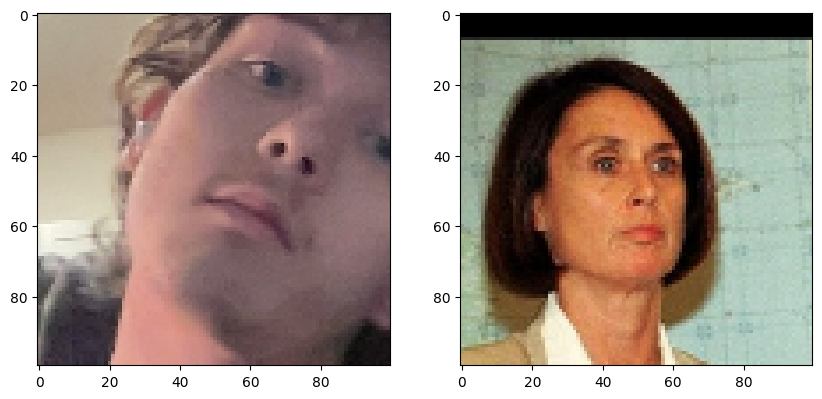

14


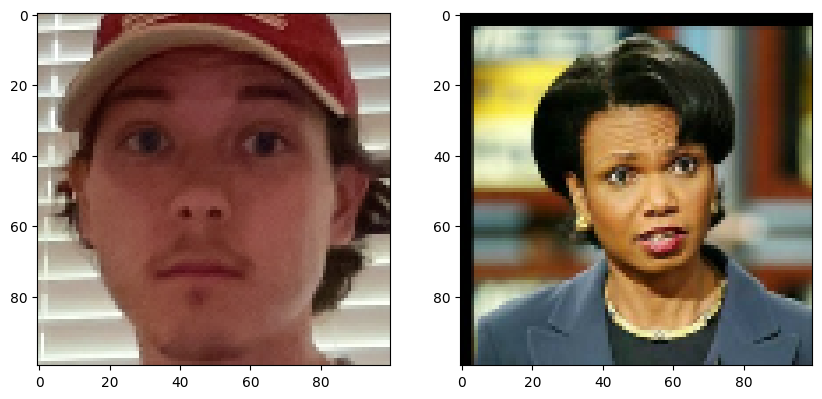

In [34]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

# Set plot size 

for i in range(0,len(y_true)):

    if y_true[i]==0:
        print(i)
        plt.figure(figsize=(10,8))

    # Set first subplot
        plt.subplot(1,2,1)
        plt.imshow(test_input[i])

    # Set second subplot
        plt.subplot(1,2,2)
        plt.imshow(test_val[i])

    # Renders cleanly
        plt.show()

In [118]:
#save the model

#save weights
siamese_model.save('siamesemodel.keras')


In [35]:
#reload the model
model = tf.keras.models.load_model('siamesemodel.keras', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})




In [36]:
#make predictions with reloaded model
model.predict([test_input,test_val])

1/1 [==============================] - 1s 827ms/step


array([[8.1226359e-10],
       [2.2657116e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [6.5681856e-09],
       [9.9017656e-01],
       [9.8773623e-01],
       [1.6386073e-08],
       [9.9995065e-01],
       [1.0000000e+00],
       [9.9928367e-01],
       [1.8267776e-09],
       [1.4674524e-11],
       [2.3657199e-06],
       [2.8018818e-10],
       [1.0000000e+00]], dtype=float32)

In [37]:
#view reloaded model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 vaidation_img (InputLayer)  [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'vaidation_img[0][0]']       
                                                                                                  
 l1_dist_3 (L1Dist)          (None, 4096)                 0         ['embedding[0][0]

In [38]:
#real time test:

# setup verification images
# build verify function
# perform recognition in real time

In [39]:
#verification function:

#acess webacm using open cv to get the input image
#verify the input against positive samples
    #50 positive samples are compared to the input for each verification round
#verification threshold: if prediciton is > 50% then it is a verified sample
#detection threshold: percentage of positive images passed the verification threshold
    #if there are 50 images trsted against the input, and 30 of them pass the verification 
    #threshhold of 50% then 30/50 -> 60% for the detection threshhold
    #provides an additional metric to confirm a positive verification


In [40]:
#take a picture from the webcam, save it into input image folder
#compare that image against the images in the verification images folder


In [41]:
#verification function

def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):   #loops throught the images in verification images folder
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))   #scale and resize input image from webcam
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))  #scale and resize images in verification folder
        
        #make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    #detection threshold
    detection = np.sum(np.array(results) > detection_threshold) 
    
    #verification threshold
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified
    


In [42]:
cap = cv2.VideoCapture(1)    #0 connects to phone, 1 connects to webcam
while cap.isOpened():
    ret, frame= cap.read()
    frame = frame[300:300+250,540:540+250,:]
    
    cv2.imshow('Verification', frame)
    
    # verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to input image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        #verification function
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 135ms/step
True
1/1 [==============================] - 0s 135ms/step
True
1/1 [==============================] - 0s 135ms/step
False
